In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

2022-07-02 22:16:34.481409: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Load data

In [2]:
data = pd.read_csv('dataset/real/insurance.csv')
data.drop(columns=['Unnamed: 0'],inplace=True)

## Preprocess data

In [3]:
# Turn all categories into numbers
insurance_one_hot = pd.get_dummies(data)
insurance_one_hot.head() # view the converted columns
# Create X & y values
X = insurance_one_hot.drop("charges", axis=1)
y = insurance_one_hot["charges"]

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state=42
)

# Model

## 1. Model with MAE

In [5]:
from pickletools import optimize
from tabnanny import verbose


tf.random.set_seed(42)
#Modeling
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1),
    tf.keras.layers.Dense(1)
])
#Compile the model
model.compile(
    loss=tf.keras.losses.mae,
    optimizer=tf.keras.optimizers.SGD(),
    metrics=['mae']
)

#Fit the model
model.fit(X_train, y_train, epochs=100, verbose = 0)

2022-07-02 22:16:36.870345: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-07-02 22:16:36.870371: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: tari-Nitro-AN515-56
2022-07-02 22:16:36.870376: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: tari-Nitro-AN515-56
2022-07-02 22:16:36.870478: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.129.6
2022-07-02 22:16:36.870491: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.129.6
2022-07-02 22:16:36.870494: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.129.6
2022-07-02 22:16:36.871034: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions i

In [6]:
loss,mae =  model.evaluate(X_test, y_test, verbose=0)
print(f'Loss: {loss}')
print(f'MAE: {mae}')

Loss: 8628.2373046875
MAE: 8628.2373046875


## 2. Model with MSE

In [7]:
from pickletools import optimize
from tabnanny import verbose


tf.random.set_seed(42)
#Modeling
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1),
    tf.keras.layers.Dense(1)
])
#Compile the model
model.compile(
    loss=tf.keras.losses.mae,
    optimizer=tf.keras.optimizers.SGD(),
    metrics=['mse']
)

#Fit the model
model.fit(X_train, y_train, epochs=100, verbose = 0)

In [8]:
loss, mae =  model.evaluate(X_test, y_test, verbose=0)
print(f'Loss mae: {loss}')
print(f'MSE: {mae}')

Loss mae: 8628.2373046875
MSE: 108074120.0


## 3. Model with R2

In [9]:
from tensorflow_addons.metrics.r_square import RSquare
import tensorflow_addons as tfa

In [10]:
tb_callback = tf.keras.callbacks.TensorBoard('./logs', update_freq=1)


In [11]:
# Modeling
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Dense(1),
])

# Compile
model.compile(
    loss=tf.keras.losses.mae,
    optimizer = tf.keras.optimizers.Adam(),
    metrics=[tfa.metrics.r_square.RSquare()]
)

# Fit the model
model.fit(X_train, y_train, epochs= 100, verbose=0, callbacks=[tb_callback])

In [12]:
model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 1ms/step - loss: 3536.4995 - r_square: 0.7056


[3536.49951171875, 0.7055687308311462]

# Tensorboard and Custom Early Stoping

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow_addons.metrics.r_square import RSquare
import pandas as pd

2022-07-02 22:22:25.461107: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
data = pd.read_csv('dataset/real/insurance.csv')
data.drop(columns=['Unnamed: 0'],inplace=True)
# Turn all categories into numbers
insurance_one_hot = pd.get_dummies(data)
insurance_one_hot.head() # view the converted columns
# Create X & y values
X = insurance_one_hot.drop("charges", axis=1)
y = insurance_one_hot["charges"]

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state=42
)

In [4]:
class ErlyStopByR2(tf.keras.callbacks.Callback):
    def __init__(self, patient=10):
        super(tf.keras.callbacks.Callback, self).__init__()
        self.patient = patient
        self.best_weights = None
        self.min_score = 0.0
        self.curr_patient = 0
    def on_epoch_end(self, epoch, logs={}):
        val_score = logs['val_r_square']
        if self.curr_patient > self.patient:
            print("Epoch %05d: early stopping Threshold" % epoch)
            self.model.stop_training = True
            self.model.set_weights(self.best_weights)
        else:
            if val_score > self.min_score:
                print(f"Improve from {self.min_score} to {val_score}")
                self.min_score = val_score
                self.curr_patient = 0
                self.best_weights = self.model.get_weights()
            else:
                self.curr_patient+=1

In [5]:
tb_callback = tf.keras.callbacks.TensorBoard('./logs', update_freq=1)


In [6]:
callbacks = [tb_callback,ErlyStopByR2(patient=20)]

In [7]:
X_train.shape, y_train.shape,X_test.shape, y_test.shape

((1070, 11), (1070,), (268, 11), (268,))

In [8]:
# Modeling
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Dense(1),
])

# Compile
model.compile(
    loss=tf.keras.losses.mae,
    optimizer = tf.keras.optimizers.Adam(),
    metrics=[RSquare()]
)

# Fit the model
history = model.fit(X_train.values, y_train.values, epochs= 100, verbose=0,  validation_data=(X_test.values,y_test.values), callbacks=callbacks)

2022-07-02 22:22:29.622605: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-07-02 22:22:29.622637: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: tari-Nitro-AN515-56
2022-07-02 22:22:29.622642: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: tari-Nitro-AN515-56
2022-07-02 22:22:29.622767: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.129.6
2022-07-02 22:22:29.622782: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.129.6
2022-07-02 22:22:29.622786: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.129.6
2022-07-02 22:22:29.623204: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions i

Improve from 0.0 to 0.0027176737785339355
Improve from 0.0027176737785339355 to 0.004666328430175781
Improve from 0.004666328430175781 to 0.01914757490158081
Improve from 0.01914757490158081 to 0.02573305368423462
Improve from 0.02573305368423462 to 0.033097147941589355
Improve from 0.033097147941589355 to 0.036992788314819336
Improve from 0.036992788314819336 to 0.05334669351577759
Improve from 0.05334669351577759 to 0.06021219491958618
Improve from 0.06021219491958618 to 0.07775986194610596
Improve from 0.07775986194610596 to 0.08365863561630249
Improve from 0.08365863561630249 to 0.09537762403488159
Improve from 0.09537762403488159 to 0.09616625308990479
Improve from 0.09616625308990479 to 0.12277239561080933
Improve from 0.12277239561080933 to 0.12346458435058594
Improve from 0.12346458435058594 to 0.1353054642677307
Improve from 0.1353054642677307 to 0.15635836124420166
Improve from 0.15635836124420166 to 0.17430460453033447
Improve from 0.17430460453033447 to 0.18830901384353638


In [10]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'epochs')

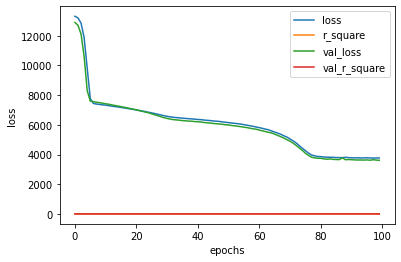

In [11]:
# Plot history (also known as a loss curve)
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs")

In [12]:
# Evaulate 3rd model by metrics
model_loss, model_r2 = model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 868us/step - loss: 3608.7935 - r_square: 0.6713


In [23]:
%load_ext tensorboard